## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [10]:
from keras.layers import BatchNormalization

def build_mlp(input_shape,output_units=10,neurons=[512,256,128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    for i,n in enumerate(neurons):
        if i == 0:
            x = keras.layers.Dense(units=n,
                                   activation='relu',
                                   name='hidden_layer'+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n,
                                   activation='relu',
                                   name='hidden_layer'+str(i+1))(x)
            x = BatchNormalization()(x)
    out = keras.layers.Dense(units=output_units,
                             activation='softmax',
                             name='output')(x)
    model = keras.models.Model(inputs=[input_layer],outputs=[out])
    return model

In [11]:
"""Code Here
設定超參數
"""
Learning_rate = 1e-3
Epochs = 50
Batch_size = 1024
Momemtum = 0.95
Monitors=['val_loss','val_acc']
Patience = [5,10,25]

In [12]:
for i,(M,P) in enumerate(itertools.product(Monitors,Patience)):
    print('exp%i:monitor:%s with patience:%i'%(i,M,P))

exp0:monitor:val_loss with patience:5
exp1:monitor:val_loss with patience:10
exp2:monitor:val_loss with patience:25
exp3:monitor:val_acc with patience:5
exp4:monitor:val_acc with patience:10
exp5:monitor:val_acc with patience:25


In [13]:
# 載入 Callbacks
"""Code Here
設定 callbacks: Earlystop
"""
from keras.callbacks import EarlyStopping
import itertools
results = {}

for i,(M,P) in enumerate(itertools.product(Monitors,Patience)):
    keras.backend.clear_session()
    print('exp%i:monitor:%s with patience:%i'%(i,M,P))
    earlystop = EarlyStopping(monitor=M,patience=P,verbose=1)
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=Learning_rate,
                                     momentum=Momemtum,
                                     nesterov=True)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
                  optimizer = optimizer)
    model.fit(x_train,y_train,
              epochs=Epochs,batch_size=Batch_size,
              validation_data=(x_test,y_test),
              shuffle=True,
              callbacks=[earlystop])
    exp_tag = 'exp%i:monitor:%s with patience:%i'%(i,M,P)
    train_loss = model.history.history['loss']
    valid_loss = model.history.history['val_loss']
    train_acc = model.history.history['acc']
    valid_acc = model.history.history['val_acc']
    
    results[exp_tag] = {'train-loss':train_loss,
                        'valid-loss':valid_loss,
                        'train-acc':train_acc,
                        'valid-acc':valid_acc
        
    }
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

exp0:monitor:val_loss with patience:5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3

Epoch 12/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.2511 - acc: 0.5658 - val_loss: 1.4844 - val_acc: 0.4773
Epoch 13/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.2274 - acc: 0.5749 - val_loss: 1.4750 - val_acc: 0.4837
Epoch 14/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.2017 - acc: 0.5854 - val_loss: 1.4747 - val_acc: 0.4831
Epoch 15/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.1767 - acc: 0.5944 - val_loss: 1.4727 - val_acc: 0.4849
Epoch 16/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.1550 - acc: 0.6035 - val_loss: 1.4639 - val_acc: 0.4870
Epoch 17/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.1314 - acc: 0.6117 - val_loss: 1.4616 - val_acc: 0.4869
Epoch 18/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.1096 - acc: 0.6203 - val_loss: 1.4551 - val_acc: 0.4910
Epoch 19/50
50000/50000 [=========

50000/50000 [==============================] - 2s 33us/step - loss: 0.9312 - acc: 0.6870 - val_loss: 1.4901 - val_acc: 0.4886
Epoch 28/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.9105 - acc: 0.6949 - val_loss: 1.4798 - val_acc: 0.4893
Epoch 29/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.8899 - acc: 0.7049 - val_loss: 1.5090 - val_acc: 0.4843
Epoch 30/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.8683 - acc: 0.7122 - val_loss: 1.5066 - val_acc: 0.4908
Epoch 31/50
50000/50000 [==============================] - 2s 34us/step - loss: 0.8527 - acc: 0.7184 - val_loss: 1.5140 - val_acc: 0.4925
Epoch 32/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.8321 - acc: 0.7286 - val_loss: 1.5192 - val_acc: 0.4870
Epoch 33/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.8125 - acc: 0.7333 - val_loss: 1.5203 - val_acc: 0.4882
Epoch 34/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s 45us/step - loss: 2.1976 - acc: 0.2715 - val_loss: 2.1191 - val_acc: 0.2960
Epoch 2/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.7432 - acc: 0.3929 - val_loss: 1.7811 - val_acc: 0.3886
Epoch 3/50
50000/50000 [==============================] - 2s 34us/step - loss: 1.6168 - acc: 0.4357 - val_loss: 1.7102 - val_acc: 0.3986
Epoch 4/50
50000/50000 [==============================] - 2s 34us/step - loss: 1.5409 - acc: 0.4609 - val_loss: 1.6250 - val_acc: 0.4309
Epoch 5/50
50000/50000 [==============================] - 2s 34us/step - loss: 1.4859 - acc: 0.4826 - val_loss: 1.6046 - val_acc: 0.4370
Epoch 6/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.4425 - acc: 0.4977 - val_loss: 1.5595 - val_acc: 0.4488
Epoch 7/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.4003 - acc: 0.5131 - val_loss: 1.5474 - val_acc

50000/50000 [==============================] - 2s 33us/step - loss: 1.3388 - acc: 0.5357 - val_loss: 1.5182 - val_acc: 0.4641
Epoch 10/50
50000/50000 [==============================] - 2s 34us/step - loss: 1.3086 - acc: 0.5464 - val_loss: 1.5019 - val_acc: 0.4730
Epoch 11/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.2807 - acc: 0.5577 - val_loss: 1.4883 - val_acc: 0.4780
Epoch 12/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.2523 - acc: 0.5656 - val_loss: 1.4865 - val_acc: 0.4814
Epoch 13/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.2289 - acc: 0.5774 - val_loss: 1.4858 - val_acc: 0.4778
Epoch 14/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.2044 - acc: 0.5846 - val_loss: 1.4915 - val_acc: 0.4809
Epoch 15/50
50000/50000 [==============================] - 2s 33us/step - loss: 1.1807 - acc: 0.5961 - val_loss: 1.4777 - val_acc: 0.4826
Epoch 16/50
50000/50000 [=====================

'Code Here\n撰寫你的訓練流程並將結果用 dictionary 紀錄\n'

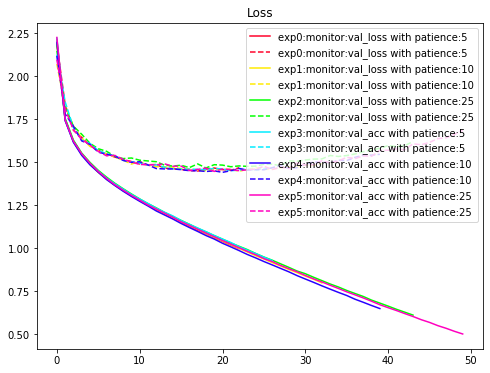

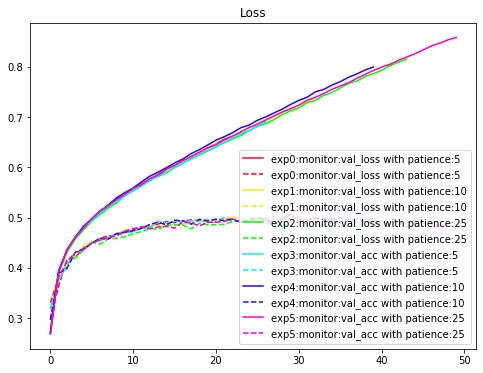

In [18]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
Num_colors = len(list(itertools.product(Monitors,Patience)))
cm = plt.get_cmap('gist_rainbow')
cNorm = colors.Normalize(vmin=0, vmax=Num_colors-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm,cmap=cm)
color_bar=[scalarMap.to_rgba(i) for i in range(Num_colors)]

plt.figure(figsize=(8,6))
for i,cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'],'-',label=cond,color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'],'--',label=cond,color=color_bar[i])
plt.title('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i,cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'],'-',label=cond,color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'],'--',label=cond,color=color_bar[i])
plt.title('Loss')
plt.legend()
plt.show()
